In [1]:
import os
from collections import OrderedDict

import torch 
import scipy.io
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F

from tqdm import trange

from pylab import meshgrid
from matplotlib import pyplot as plt

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

**Two functions**
1. $f(x,t)$ -> function to calculate the residual of the NN output
2. $u(x,t)$ -> NN

* $n_u$ is intial and boundary points
    * sample -> (t, x)
    * if sample[0] in (0, 1) or sample[1] in (-1,1): add to BC_IC_pts
    * else: add to collocation points
    
    
    
* $n_f$ is collocation points


* $n_u$ = 100 and $n_f$ = 10,000

* With 8 Hidden layers with each 40 neurons, gives an $L_2$ error of $5.6e−04$



In [2]:
DATA_PATH = "../Data/burgers_shock.mat"
data_dict = scipy.io.loadmat(DATA_PATH)

n_u, n_f = 100, 10000

x_data,t_data, u_data = data_dict['x'], data_dict['t'], data_dict['usol']
x_data.shape, t_data.shape, u_data.shape

((256, 1), (100, 1), (256, 100))

In [3]:
u_t, u_x = meshgrid(t_data, x_data)
u_t.shape, u_x.shape

((256, 100), (256, 100))

In [4]:
u_data_transformed = u_data.flatten()[:, None] # (25600,1)
training_points = np.hstack((u_t.flatten()[:, None], u_x.flatten()[:, None])) # (25600, 2)


In [5]:
IC_X, IC_Y = list(), list() # Initial and boundary points
CC_X, CC_Y = list(), list() # Collocation points

for idx, sample in enumerate(training_points):
    
    t, x = sample
    if t in [0,1] or x in [-1,1]:
        IC_X.append(sample)
        IC_Y.append(u_data_transformed[idx])
    else:
        CC_X.append(sample)
        CC_Y.append(u_data_transformed[idx])
        
IC_X = np.array(IC_X)
IC_Y = np.array(IC_Y)

CC_X = np.array(CC_X)
CC_Y = np.array(CC_Y)

In [6]:
n_u_idx = list(np.random.choice(len(IC_X), n_u))
n_f_idx = list(np.random.choice(len(CC_X), n_f))

u_x = torch.tensor(IC_X[n_u_idx, 1:2], requires_grad=True).float()
u_t = torch.tensor(IC_X[n_u_idx, 0:1], requires_grad=True).float()
u_u = torch.tensor(IC_Y[n_u_idx, :], requires_grad=True).float()

f_x = torch.tensor(CC_X[n_f_idx, 1:2], requires_grad=True).float()
f_t = torch.tensor(CC_X[n_f_idx, 0:1], requires_grad=True).float()
f_u = torch.tensor(CC_Y[n_f_idx, :], requires_grad=True).float()

train_x = torch.cat((u_x, f_x), dim=0)
train_t = torch.cat((u_t, f_t), dim=0)
train_u = torch.cat((u_u, f_u), dim=0)

In [7]:
class PhysicsINN(nn.Module):
    
    '''
    Physics Informed Neural Network
    Written: Siddesh Sambasivam Suseela
    
    '''
    
    def __init__(self, num_layers:int=2, num_neurons:int=20) -> None:
        
        super(PhysicsINN, self).__init__()
        
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        
        # Each hidden layer contained 20 neurons and a hyperbolic tangent activation function.
        self.activation_func = torch.nn.Tanh
        
        ordered_layers = list()
                
        ordered_layers.append(("input_layer", nn.Linear(2, self.num_neurons)))
        ordered_layers.append(("input_activation", self.activation_func()))
        
        # Create num_layers-2 linear layers with num_neuron neurons and tanh activation function
        for i in range(self.num_layers-2):
            
            ordered_layers.append(("layer_%d" % (i+1), nn.Linear(self.num_neurons, self.num_neurons)))
            ordered_layers.append(("layer_%d_activation" % (i+1), self.activation_func()))
                        
        ordered_layers.append(("output_layer", nn.Linear(self.num_neurons, 1)))
        
        self.net = nn.Sequential(OrderedDict(ordered_layers))    
        
        self.init_weights()
        
    def init_weights(self, ) -> None:
        """
        Initializes the weights and biases of all the layers in the model
        
        NOTE: According to the paper, the model's weights are initialized by xaviers' distribution
        and biases are initialized as zeros
        
        """
        for param in self.parameters():
            if len(param.shape) >= 2: torch.nn.init.xavier_normal_(param, )
            elif len(param.shape) == 1: torch.nn.init.zeros_(param)

        
    def forward(self, inputs) -> torch.Tensor:
        '''returns the output from the model'''
        
        out = self.net(inputs)

        return out 
    
model = PhysicsINN(4, 40)

# Flexible HP
# 1. Hidden layers
# 2. Num_neurons
# 3. Activation functions

# Check the layer sizes
for param in model.parameters():
    print(type(param), param.size())
    

<class 'torch.nn.parameter.Parameter'> torch.Size([40, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([40])
<class 'torch.nn.parameter.Parameter'> torch.Size([40, 40])
<class 'torch.nn.parameter.Parameter'> torch.Size([40])
<class 'torch.nn.parameter.Parameter'> torch.Size([40, 40])
<class 'torch.nn.parameter.Parameter'> torch.Size([40])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 40])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])


In [11]:
EPOCHS = 100
optimizer = torch.optim.LBFGS(model.parameters())

t_bar = trange(EPOCHS)

for epoch in t_bar:
    
    def closure():
        optimizer.zero_grad()
        
        output = model(torch.cat((train_t, train_x), dim=1))
        
        u_grad_x =  torch.autograd.grad(output, train_x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        u_grad_xx = torch.autograd.grad(u_grad_x, train_x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        
        u_grad_t = torch.autograd.grad(output, train_t, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        
        f = u_grad_t + output*u_grad_x - (0.01/np.pi) * u_grad_xx
        
        mse_f = torch.mean(torch.square(f))
        mse_u = torch.mean(torch.square(output - train_u))
        
        loss = mse_f + mse_u
        
        loss.backward()
        
        t_bar.set_description("loss: %.20f" % loss.item())
        t_bar.refresh() # to show immediately the update
    
        return loss
    
    optimizer.step(closure)
        

loss: 0.00021063242456875741: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


### Neural Network has 2 Hidden layers with 40 neurons
1. For 100 Epochs: $0.9e-1$

2. For 200 Epochs: $0.6e-3$

0.02913970686495304108

0.02671100944280624390

In [75]:
test_X = [[], [], []]
test_Y = [[], [], []]

for idx, sample in enumerate(training_points):
    
    t, x = sample
    if t == 0.25:
        test_X[0].append(sample)
        test_Y[0].append(u_data_transformed[idx])
        
    if t == 0.50:
        test_X[1].append(sample)
        test_Y[1].append(u_data_transformed[idx])        
        
    if t == 0.75:
        test_X[2].append(sample)
        test_Y[2].append(u_data_transformed[idx])        

In [54]:
test_X[0][0], test_Y[0][1]

(array([ 0.15, -1.  ]), array([0.01671071]))

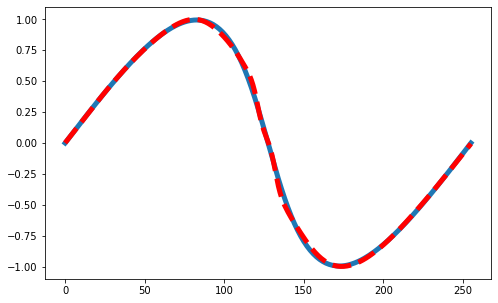

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(test_Y[0],  linewidth=5)
ax.plot(model(torch.tensor(test_X[0]).float()).detach().numpy(), "r--", linewidth=5)

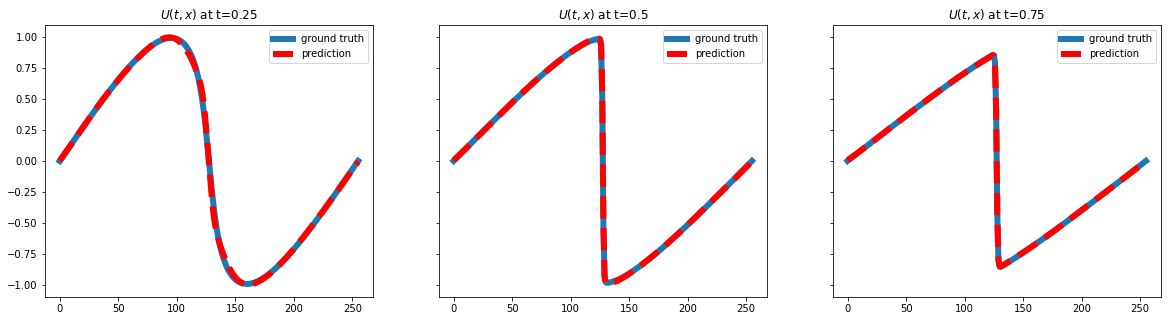

In [119]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))
width = 6

for i,t in enumerate([0.25, 0.50, 0.75]):
    
    axs[i].set_title(f"$U(t,x)$ at t={t}")
    axs[i].plot(test_Y[i],  linewidth=width, label="ground truth")
    axs[i].plot(model(torch.tensor(test_X[i]).float()).detach().numpy(), "r--", linewidth=width, label='prediction')
    axs[i].legend(loc='upper right')
    
#     axs[i].set_xlim(-1,1)    
#     axs[i].set_ylim(-1,1)    


fig.savefig('model_prediction.png')

In [101]:
np.stack((model(torch.tensor(test_X[i]).float()).detach().numpy().flatten(), np.array([list(x) for x in test_X[0]])[:, 1]), axis=-1)

array([[ 0.00503904, -1.        ],
       [ 0.01180881, -0.99215686],
       [ 0.01861006, -0.98431373],
       [ 0.02544111, -0.97647059],
       [ 0.03230196, -0.96862745],
       [ 0.03919154, -0.96078431],
       [ 0.04610866, -0.95294118],
       [ 0.05305332, -0.94509804],
       [ 0.06002432, -0.9372549 ],
       [ 0.06702143, -0.92941176],
       [ 0.0740425 , -0.92156863],
       [ 0.08108789, -0.91372549],
       [ 0.08815569, -0.90588235],
       [ 0.09524566, -0.89803922],
       [ 0.10235697, -0.89019608],
       [ 0.10948759, -0.88235294],
       [ 0.11663741, -0.8745098 ],
       [ 0.12380558, -0.86666667],
       [ 0.13099033, -0.85882353],
       [ 0.13819057, -0.85098039],
       [ 0.14540619, -0.84313725],
       [ 0.15263516, -0.83529412],
       [ 0.15987688, -0.82745098],
       [ 0.16713017, -0.81960784],
       [ 0.17439359, -0.81176471],
       [ 0.18166679, -0.80392157],
       [ 0.18894809, -0.79607843],
       [ 0.19623655, -0.78823529],
       [ 0.20353132,

In [103]:
model(torch.tensor(test_X[i]).float()).detach().numpy()[1]

array([0.01180881], dtype=float32)